In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Preparing Dataset

In [1]:
words = open("names.txt", "r").read().splitlines()

In [8]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
vocab_size

27

In [7]:


block_size = 3
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w+".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)   

    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

### Creating layers

In [12]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)


W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr.to(device), Ytr.to(device)
for p in parameters:
    p.to(device)

In [16]:

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
      


      0/ 200000: 26.7832
  10000/ 200000: 2.9658
  20000/ 200000: 2.2589
  30000/ 200000: 2.2723
  40000/ 200000: 2.1396
  50000/ 200000: 1.7821
  60000/ 200000: 2.2356
  70000/ 200000: 2.3465
  80000/ 200000: 1.9260
  90000/ 200000: 1.7438
 100000/ 200000: 2.5454
 110000/ 200000: 2.1703
 120000/ 200000: 2.6916
 130000/ 200000: 1.8312
 140000/ 200000: 1.8955
 150000/ 200000: 2.3153
 160000/ 200000: 1.7943
 170000/ 200000: 1.9758
 180000/ 200000: 2.4061
 190000/ 200000: 2.1174


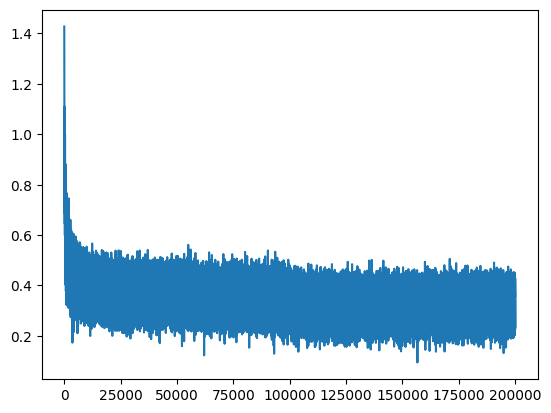

In [18]:
plt.plot(list(range(200000)), lossi)

### Evaluation

In [19]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.1158761978149414
dev 2.168163776397705


In [20]:
torch.cuda.empty_cache() 

### Sample from the model

In [30]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)

        ix = torch.multinomial(prob, num_samples=1, generator = g)
        out.append(ix.item())
        context = context[1:]+[ix]

        if ix==0:
            break
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nihahaley.
thrus.
jarlei.
aderedielin.
emilopaleigh.
estanaraelynn.
hone.
